In [1]:
import Data_acq as data
from models import Encoder
from models import Decoder
from models import cVAE
import importlib

Datos

In [54]:
import importlib
importlib.reload(data)
x_train, x_test,x_val ,y_train, y_test,y_val, x_train_1, y_train_1 = data.get_mnist_data()

print("="*70)
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"x_val: {x_val.shape}\n")
print("-"*70)
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"y_val: {y_val.shape}\n")
print("primer elemento")
print(f"primer elemento del set de entrenamineto shape: {x_train[0].shape}\n")
print(f"primer elemento del set de entrenamineto: {x_train[0]}")

print(f"primer label del set de entrenamineto shape: {y_train[0].shape}\n")
print(f"primer label del set de entrenamineto: {y_train[0]}")

print("="*70)


x_train: (55000, 28, 28)
x_test: (10000, 28, 28)
x_val: (5000, 28, 28)

----------------------------------------------------------------------
y_train: (55000, 10)
y_test: (10000, 10)
y_val: (5000, 10)

primer elemento
primer elemento del set de entrenamineto shape: (28, 28)

primer elemento del set de entrenamineto: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0

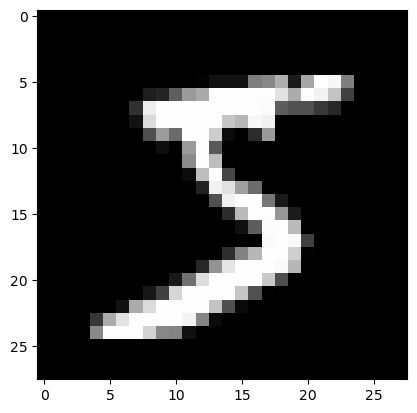

In [3]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0],cmap="gray")
plt.show()

Enconder


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[[-5.00652015e-01  4.71841604e-01  1.44598454e-01 -4.36473131e-01
   1.27964541e-01  3.44710112e-01 -1.05541326e-01  1.62441790e-01
   5.45467585e-02  1.15513921e-01 -1.54392675e-01  3.51113118e-02
  -4.36301082e-02 -2.69681782e-01  2.30663158e-02 -4.15457860e-02
   2.04841614e-01 -8.22020620e-02  2.30562463e-01 -7.57944882e-02
   5.43403864e-01 -8.35903168e-01 -6.01186991e-01  2.14202419e-01
  -3.76711726e-01 -4.90101725e-01 -1.59100935e-01  3.96865249e-01
  -7.65268445e-01  3.61532569e-02 -1.42902315e-01 -2.10195780e-01
  -3.30400735e-01  1.07933156e-01 -2.44094387e-01  2.38211691e-01
  -8.82785767e-03  3.33927959e-01 -1.59535468e-01 -1.92790121e-01
   9.83887762e-02 -5.80501378e-01  1.12974092e-01  2.29066715e-01
  -1.09036118e-01  2.16730893e-01  1.49124525e-02  3.81442487e-01
   4.70688671e-01 -1.25984848e-02  1.63507149e-01  6.44306168e-02
   1.20007777e+00 -9.22944546e-02 -3.59347671e-01 -1.96664035e-0

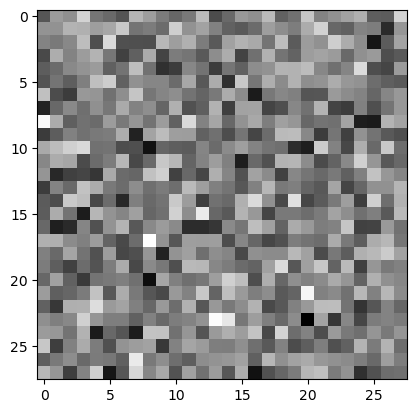

In [4]:
import importlib
import numpy as np
importlib.reload(Encoder)
importlib.reload(Decoder)

#img_dim=(28,28),condition_dim=(10,),intermediate_dim=128,latent_dim=2
#latent_dim=2, cond_dim=(10,), intermediate_dim=128, original_shape=(28, 28)

en = Encoder.build_enconder(intermediate_dim=512,latent_dim=256)
de = Decoder.build_decoder(intermediate_dim=512,latent_dim=256)


img_sample = np.expand_dims(x_train[0], axis=0)  # shape (1, 28, 28)
cond_sample = np.expand_dims(y_train[0], axis=0) 

[z, z_mean, z_log_var] = en.predict([img_sample,cond_sample])

img_recons = de.predict([z,cond_sample])

print(z)
print(z_mean)
print(z_log_var)
print(img_recons[0].shape)

plt.imshow(img_recons[0],cmap="gray")
plt.show()


In [50]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

importlib.reload(cVAE)
original_dim = 28*28
beta = 1.0

train_dataset = tf.data.Dataset.from_tensor_slices(((x_train, y_train), x_train))
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset = train_dataset.batch(128)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

val_dataset = tf.data.Dataset.from_tensor_slices(((x_val, y_val), x_val))
val_dataset = val_dataset.batch(128)


cvae = cVAE.CVAE(encoder=en, decoder=de, original_dim=original_dim, beta=1.0)
cvae.compile(optimizer=tf.keras.optimizers.Adam())

cvae.fit(train_dataset,
        epochs=2,
        batch_size=128,
        validation_data=val_dataset,
        callbacks=[early_stopping]
         )

Epoch 1/2
 59/430 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - kl_loss: 5.3610 - loss: 35.8797 - reconstruction_loss: 30.5186

KeyboardInterrupt: 

In [6]:
#cvae.fit(train_dataset, epochs=10,batch_size=128)

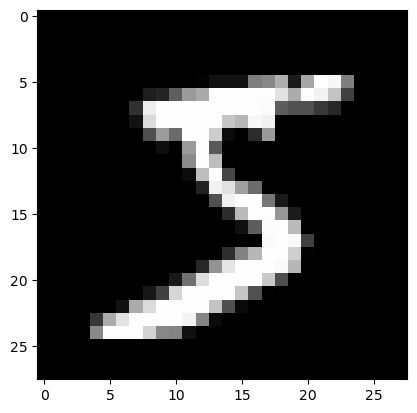

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(1, 28, 28)


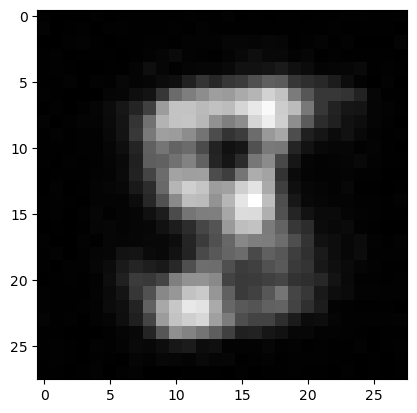

In [7]:
x_input = x_train[:1]         # 1 imagen (shape: (1, 28, 28))
cond_input = y_train[:1]      # su condición (shape: (1, 10))

plt.imshow(x_input[0],cmap="gray")
plt.show()

z_mean, z_log_var, z = cvae.encoder.predict([x_input, cond_input])

# Paso por el decoder para reconstrucción
reconstructed = cvae.decoder.predict([z, cond_input])
print(reconstructed.shape)
plt.imshow(reconstructed[0],cmap="gray")
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def visualizar_condiciones(cvae, x_input):
    """
    Muestra cómo se reconstruye una imagen de entrada bajo las 10 condiciones posibles (0 a 9).
    """
    assert x_input.shape == (28, 28) or x_input.shape == (1, 28, 28), "x_input debe tener forma (28,28) o (1,28,28)"

    # Asegurar que x_input tenga batch dimension
    if x_input.shape == (28, 28):
        x_input = np.expand_dims(x_input, axis=0)

    # Repetir la imagen 10 veces
    x_repeated = np.repeat(x_input, repeats=10, axis=0)  # (10, 28, 28)

    # Crear las 10 condiciones one-hot
    condiciones = np.eye(10)  # (10, 10)

    # Codificar
    z_mean, z_log_var, z = cvae.encoder.predict([x_repeated, condiciones])

    # Reconstruir
    reconstrucciones = cvae.decoder.predict([z, condiciones])

    # Mostrar
    plt.figure(figsize=(15, 2))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(reconstrucciones[i], cmap="gray")
        plt.title(f"Clase {i}")
        plt.axis("off")
    plt.suptitle("Reconstrucciones bajo distintas condiciones")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


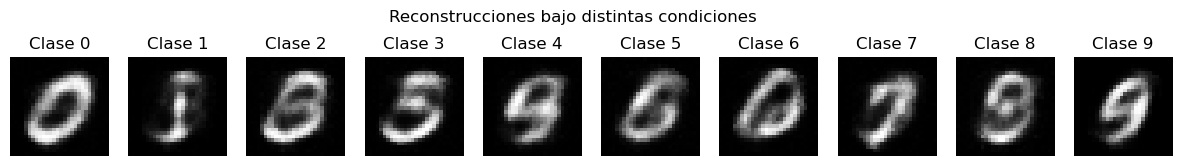

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


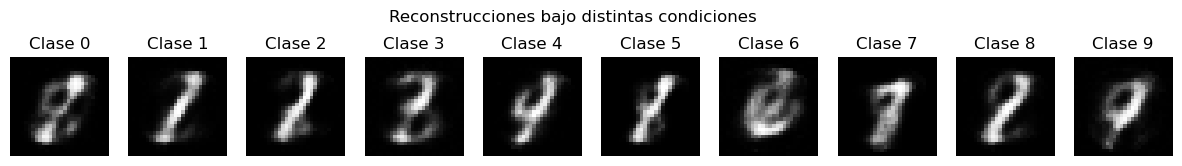

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


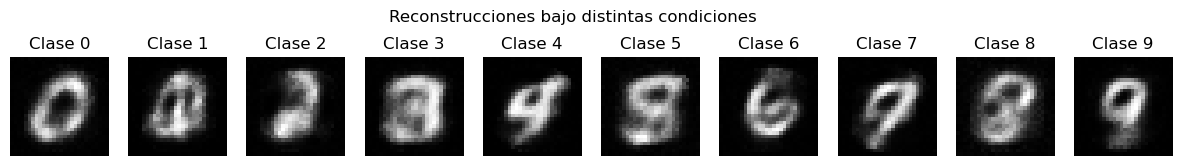

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


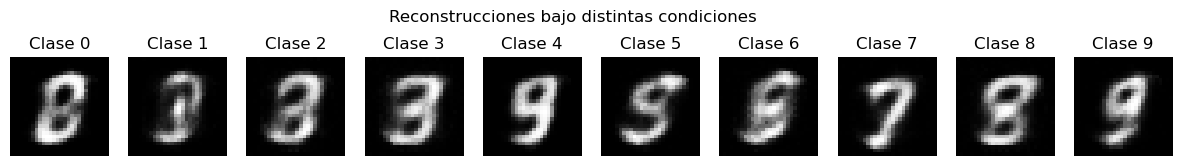

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


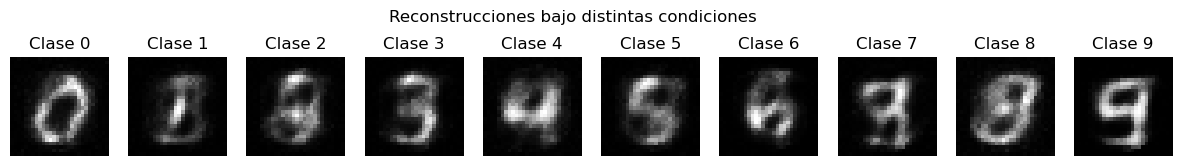

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


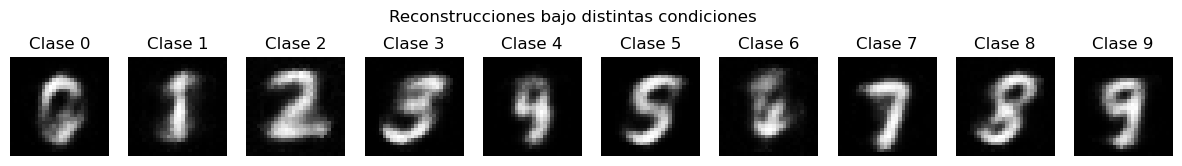

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


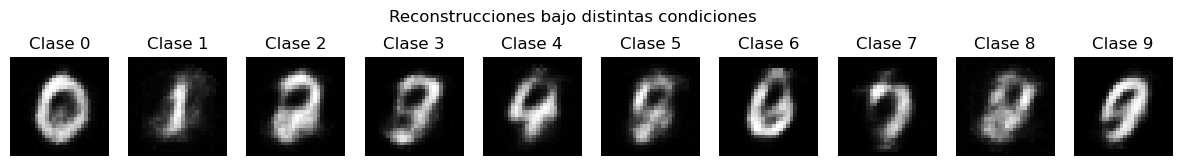

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


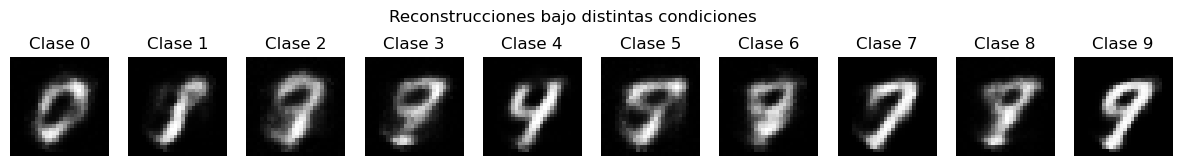

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


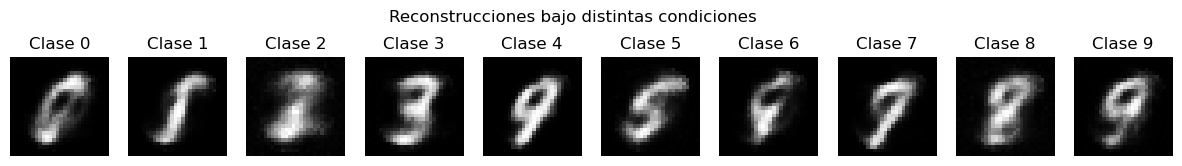

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


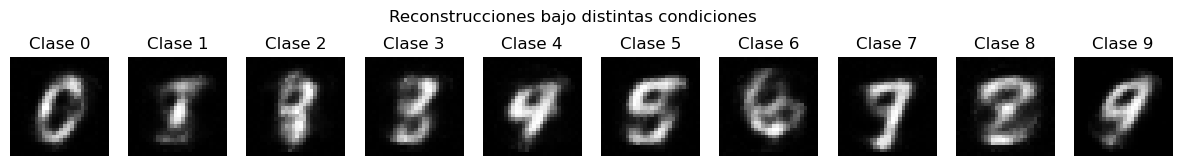

In [9]:
# Tomá una imagen del conjunto de test
indices_de_testeo=[1, 3, 5, 7, 2, 0, 13, 15, 17, 4] # inidices donde para que x_train[inidicies] sea 0 1 2 3 4 5 6 7 8 9 0


for i in indices_de_testeo:

    imagen = x_train[i]  # por ejemplo, la imagen 0
    #plt.imshow(imagen)
    #plt.show()
    # Visualizá cómo se reconstruye con todas las condiciones posibles
    visualizar_condiciones(cvae, imagen)


In [10]:
def visualizar_variantes(cvae, condicion_id, num_variantes=10):
    """
    Muestra múltiples imágenes generadas para una misma condición.
    
    Args:
        cvae: modelo CVAE entrenado.
        condicion_id: entero de 0 a 9, la clase condicional deseada.
        num_variantes: número de muestras a generar.
    """
    # Comprobar que el ID sea válido
    assert 0 <= condicion_id <= 9, "La condición debe estar entre 0 y 9."

    # Crear condición one-hot repetida
    condicion = np.eye(10)[condicion_id]
    condiciones = np.repeat([condicion], num_variantes, axis=0)  # (num_variantes, 10)

    # Generar z aleatorios ~ N(0,1)
    latent_dim = cvae.decoder.input_shape[0][1]  # obtiene la dimensión latente del input
    z = np.random.normal(size=(num_variantes, latent_dim))  # (num_variantes, latent_dim)

    # Generar imágenes con el decoder
    imgs_generadas = cvae.decoder.predict([z, condiciones])

    # Mostrar
    plt.figure(figsize=(15, 2))
    for i in range(num_variantes):
        plt.subplot(1, num_variantes, i + 1)
        plt.imshow(imgs_generadas[i], cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Variantes generadas para la clase {condicion_id}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


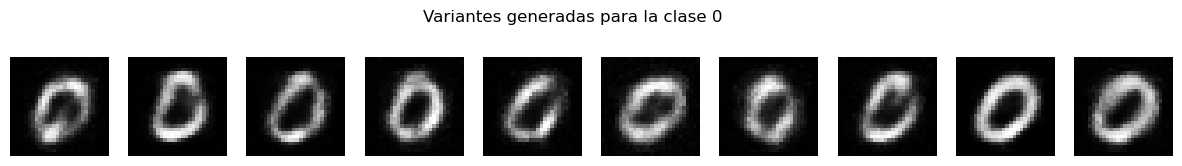

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


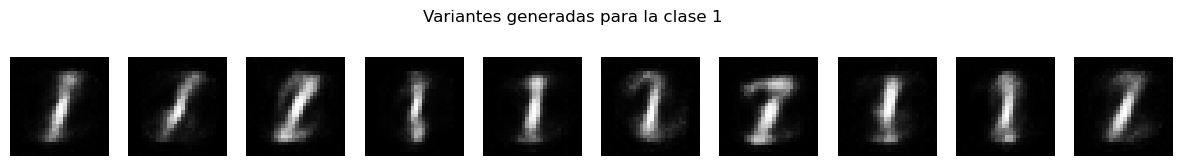

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


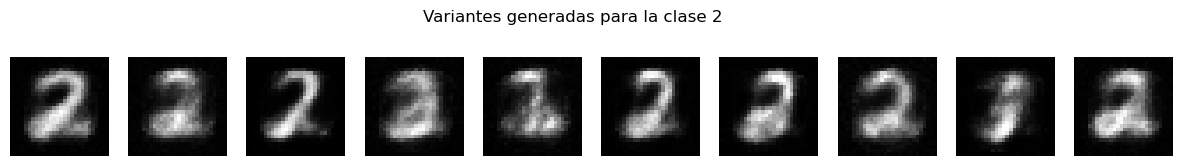

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


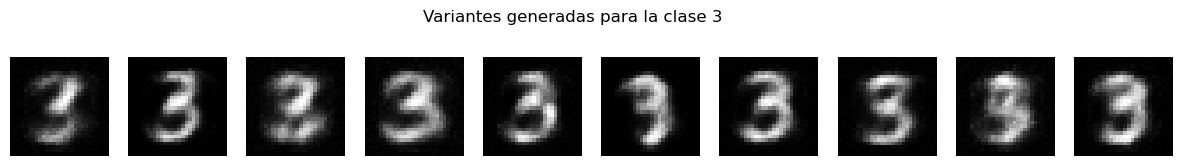

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


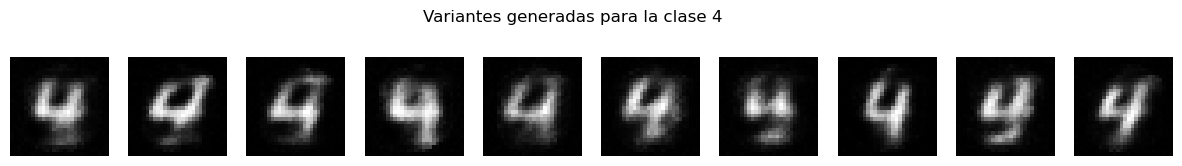

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


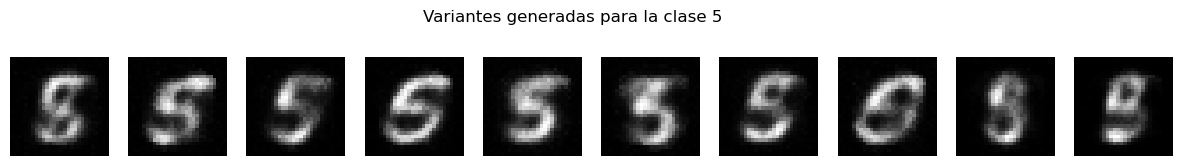

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


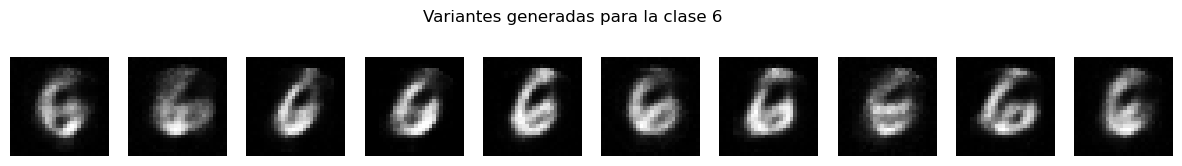

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


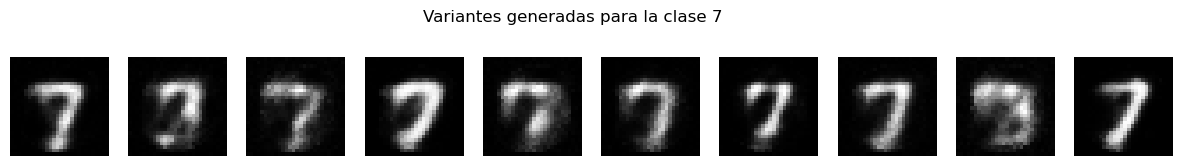

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


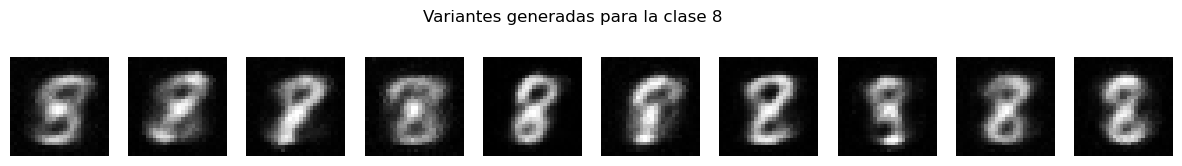

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


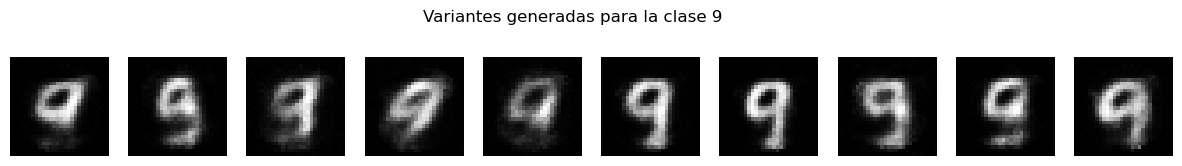

In [11]:
# Ver 10 variantes generadas para la clase 3
for i in range(10):
    
    visualizar_variantes(cvae, condicion_id=i, num_variantes=10)


# Predictores

In [12]:
import models.Predictor as predictores
importlib.reload(predictores)

predictor = predictores.build_predictor() 

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

predictor.compile(optimizer, loss="categorical_crossentropy")


predictor.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_data=(x_val, y_val)  # Include validation data
#    callbacks=[cp_callback_predictor_C2, early_stopping]  # Add early_stopping to callbacks
)

Model: "predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ original_input (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (ReshapeLayer)    │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,570 (197.54 KB)

 Trainable params: 50,378 (196.79 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.5794 - val_loss: 0.2462
Epoch 2/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.1188 - val_loss: 0.0594
Epoch 3/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0831 - val_loss: 0.0598
Epoch 4/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0702 - val_loss: 0.0535
Epoch 5/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0654 - val_loss: 0.0598


(28, 28)


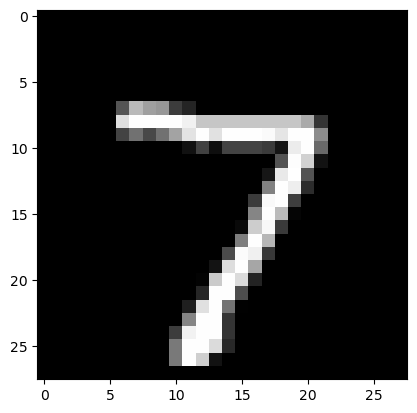

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Digito predicho:  f 7


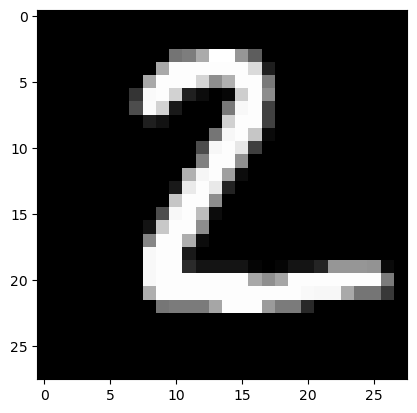

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Digito predicho:  f 2


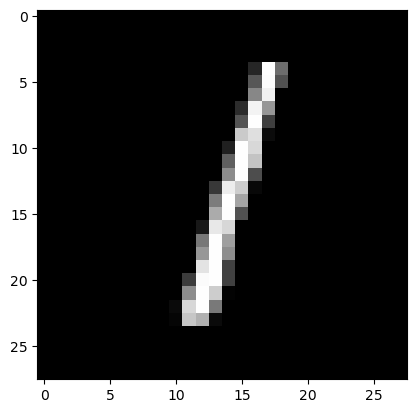

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Digito predicho:  f 1


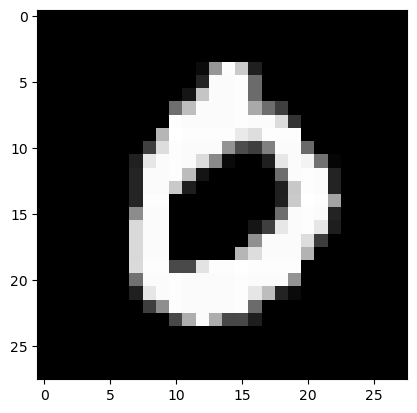

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Digito predicho:  f 0


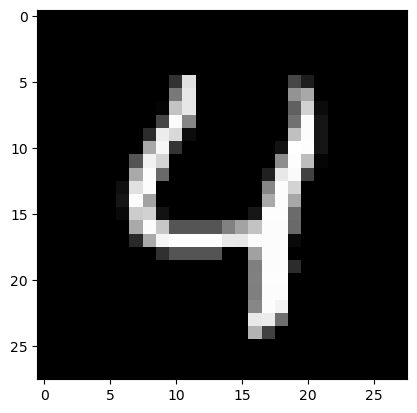

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Digito predicho:  f 4


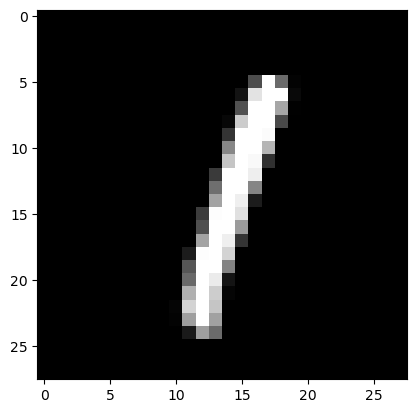

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Digito predicho:  f 1


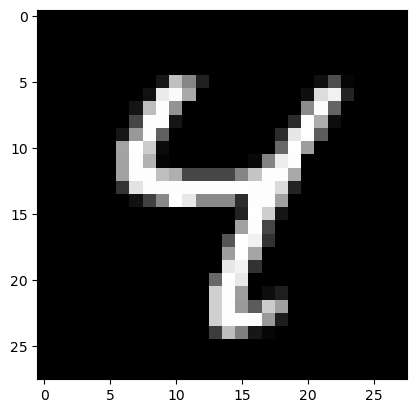

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Digito predicho:  f 4


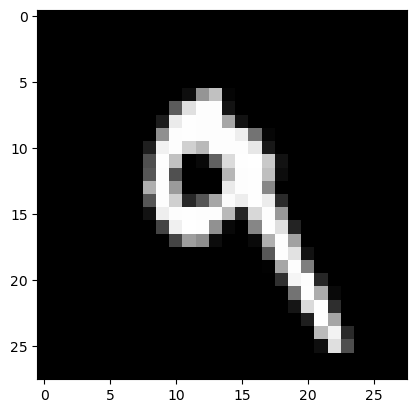

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Digito predicho:  f 9


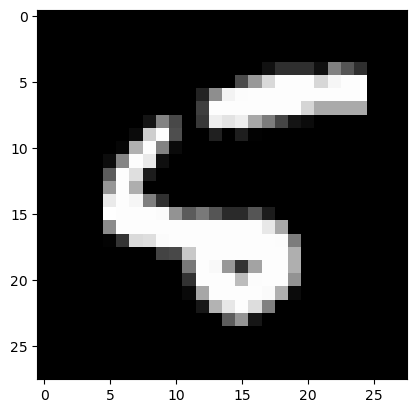

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Digito predicho:  f 6


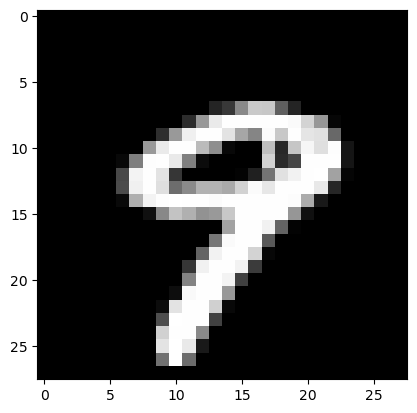

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Digito predicho:  f 9


In [13]:
print(x_test[0].shape)
for i in range(10):
    plt.imshow(x_test[i],cmap="gray")
    plt.show()
    
    print(f"Digito predicho:  f {np.argmax( predictor.predict(np.reshape(x_test[i], (28,28,1))))}")

# Pruebas de separacion de digitos


Shape de x_train
(10, 28, 28)
ITERACIÓN A:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
select_1:       tf.Tensor([0 0 1 0 1 1 0 1 0 1], shape=(10,), dtype=int64)
select_1_1:     tf.Tensor([0 1 0 1 0 1 1 0 1 0], shape=(10,), dtype=int64)
################################################################################################
formas de x y select_1 

(10, 28, 28)
(10, 28, 28)
(10, 1)
(10, 1)
################################################################################################
forma de x y de x_1 antes de aplanar: x: (10, 28, 28) x_1: (10, 28, 28)
forma de x y de x_1 despues de aplanar: x_flat:  (10, 784) y x_1_flat:  (10, 784)
y_reduced:    tf.Tensor([5 0 4 1 9 2 1 3 1 4], shape=(10,), dtype=int64)
y_1_reduced:

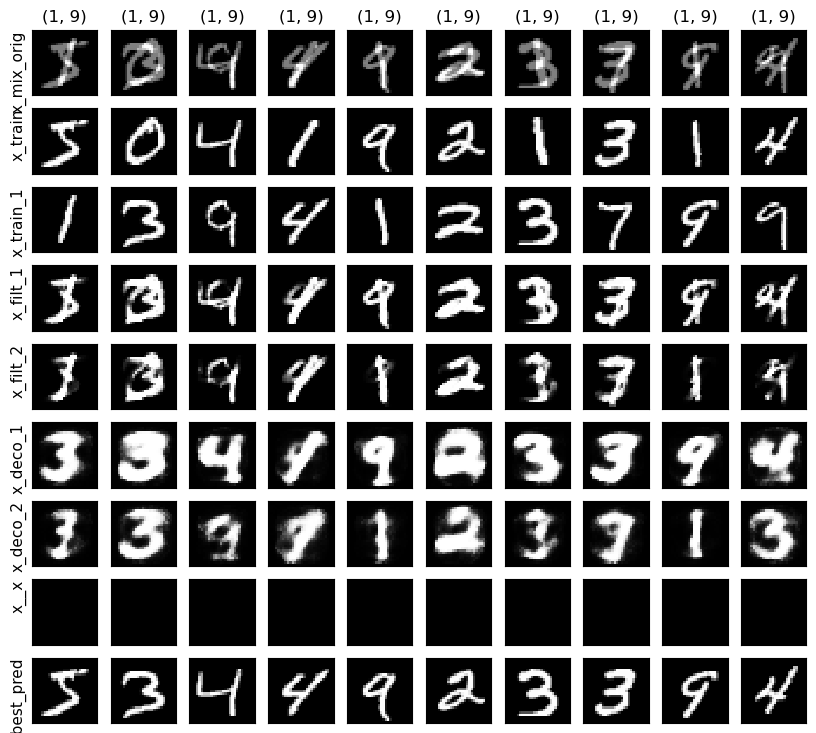

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
ITERACIÓN A:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
select_1:       tf.Tensor([0 0 1 1 1 1 0 1 0 1], shape=(10,), dtype=int64)
select_1_1:     tf.Tensor([0 1 0 0 0 1 1 0 1 0], shape=(10,), dtype=int64)
################################################################################################
formas de x y select_1 

(10, 28, 28)
(10, 28, 28)
(10, 1)
(10, 1)
################################################################################################
for

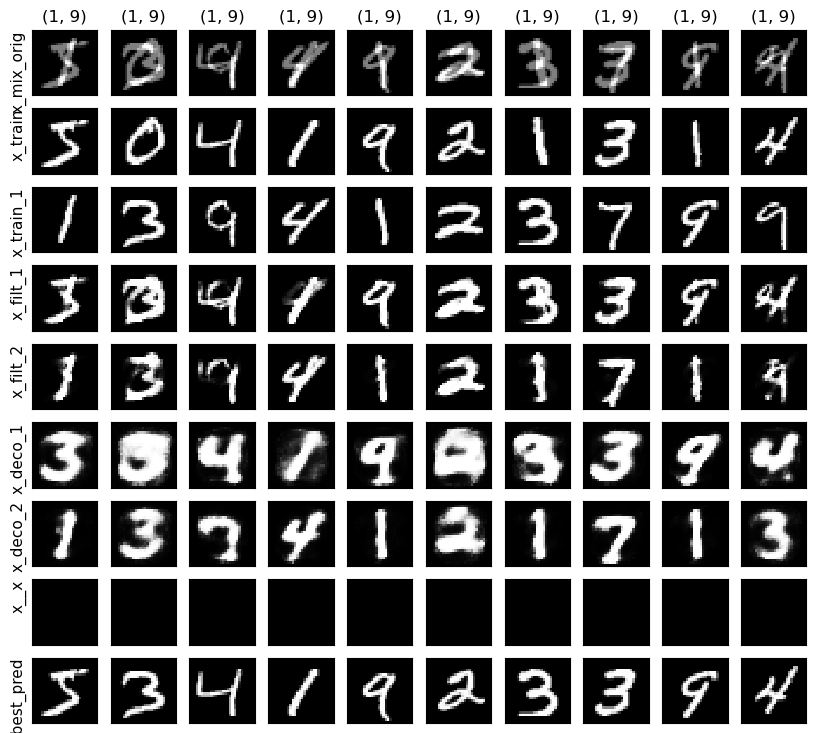

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.


In [55]:
import inferencias.inferencia as inf
import importlib
importlib.reload(inf)

inf.separar_digitos(x_train[0:10],x_train_1[0:10],y_train[0:10],y_train_1[0:10],en,de,predictor)